Claculate the solar panel area

In [1]:
import pandas as pd
import numpy as np
from openpyxl import load_workbook

# Define the file path
file_path_excel = "MFA/mask_area.xlsx"

# Load the sheet from the Excel file into a pandas DataFrame
df = pd.read_excel(file_path_excel, sheet_name='Kamakura')

# Display the first few rows of the DataFrame for verification
print("Initial DataFrame:")
print(df.head())

# Fill missing installation year data if necessary
df['installation year'].fillna(0, inplace=True)
df['mask_area'].fillna(0, inplace=True)
df['tilt_angle'].fillna(0, inplace=True)

# Create a new column 'actual_area (m2)' based on the cosine of the tilt angle with error handling
df['actual_area (m2)'] = df.apply(
    lambda row: row['mask_area'] / np.cos(np.radians(row['tilt_angle'])) if row['tilt_angle'] != 90 else 0,
    axis=1
)

# Convert area to power using the formula Power = Wp * actual_area
Wp = 176  # Power per square meter (W/m²)
df['Power'] = Wp * df['actual_area (m2)']

# Load the workbook and select the sheet explicitly
wb = load_workbook(file_path_excel)
sheet_name = 'Kamakura'
if sheet_name in wb.sheetnames:
    ws = wb[sheet_name]
else:
    raise ValueError(f"Sheet '{sheet_name}' does not exist in the Excel file.")

# Update the header cells for 'actual area (m2)' and 'Power'
ws['F1'] = 'actual area (m2)'
ws['G1'] = 'Power'

# Update the sheet with the calculated 'actual_area (m2)' and 'Power'
for idx, (actual_area, power) in enumerate(zip(df['actual_area (m2)'], df['Power']), start=2):
    ws[f'F{idx}'] = actual_area
    ws[f'G{idx}'] = power

# Save the changes back to the Excel file
wb.save(file_path_excel)

print("Updated sheet with 'actual area (m2)' and 'Power'.")

Initial DataFrame:
       city                                        file_name  mask_area  \
0  Kamakura   map_35.354020670093426_139.5083429682038_3.png  14.825659   
1  Kamakura  map_35.356120728018716_139.50490975634227_4.png   6.938048   
2  Kamakura   map_35.356120728018716_139.5134927859961_3.png   9.843726   
3  Kamakura    map_35.35682073519133_139.5452499957153_2.png  31.428218   
4  Kamakura   map_35.33861857675678_139.51778430082302_4.png  15.543217   

   tilt_angle installation year  actual area (m2)        Power  
0          33              2002         17.677572  3111.252655  
1          33              2002          8.272673  1455.990516  
2          33              2002         11.737297  2065.764321  
3          33              2002         37.473854  6595.398248  
4          33              2002         18.533161  3261.836346  
Updated sheet with 'actual area (m2)' and 'Power'.


Do the dynamic MFA calculation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import gamma


# Weibull distribution functions
def weibull_pdf(t, shape, scale):
    return (shape / scale) * (t / scale) ** (shape - 1) * np.exp(-(t / scale) ** shape)

def weibull_cdf(t, shape, scale):
    return 1 - np.exp(-(t / scale) ** shape)

# Weibull parameters
weibull_shape = 5.37 # Shape parameter (k) （2.49 or 5.37 or 8.51)
lifetime = 30         # Average lifetime (λ) in years
weibull_scale = lifetime / gamma(1 + 1 / weibull_shape)


# Load data
mask_area_df = pd.read_excel(file_path_excel, sheet_name='Kamakura')

# Filter out invalid rows and process installation years
def process_installation_year(row):
    installation_year = str(row['installation year'])
    actual_area = row['actual area (m2)']
    if 'W' in installation_year or 'w' in installation_year:
        return []
    if 'and' in installation_year:
        years = [int(year.strip()) for year in installation_year.split('and')]
        split_area = actual_area / len(years)
        return [(year, split_area) for year in years]
    try:
        return [(int(installation_year), actual_area)]
    except ValueError:
        return []

processed_data = []
for _, row in mask_area_df.iterrows():
    processed_data.extend(process_installation_year(row))

# Reverse calculate inflows for each row
inflow_by_year = {}
for installation_year, stock_2024 in processed_data:
    age = 2024 - installation_year
    survival_rate = 1 - weibull_cdf(age, weibull_shape, weibull_scale)
    if survival_rate > 0:
        inflow = stock_2024 / survival_rate
        inflow_by_year[installation_year] = inflow_by_year.get(installation_year, 0) + inflow

# # Print inflow values for debugging
# print("Inflow values by year:")
# for year, inflow in inflow_by_year.items():
#     print(f"Year {year}: {inflow:.2f} m²")

# Load material intensity data
file_path_material_flow = "MFA/material_flow.xlsx"
material_intensity_df = pd.read_excel(file_path_material_flow, sheet_name=0)
material_intensity_df.columns = material_intensity_df.columns.str.strip()

# Materials to calculate
materials = ['Ag', 'Al', 'Cu', 'Mg', 'Ni', 'Pb', 'Si', 'Sn', 'Ti', 'Zn', 'EVA', 'Glass', 'Steel']
total_inflow_by_year = {year: {material: 0 for material in materials} for year in inflow_by_year.keys()}

# Assign material inflows
for year, inflow_area in inflow_by_year.items():
    material_intensity = material_intensity_df[material_intensity_df['year/material intensity (kg/m2)'] == year]
    if material_intensity.empty:
        continue
    for material in materials:
        intensity_value = material_intensity[material].values[0]
        total_inflow_by_year[year][material] = inflow_area * intensity_value

# Initialize stock and outflow dictionaries
stock_by_year = {year: {material: 0 for material in materials} for year in range(2000, 2051)}
outflow_by_year = {year: {material: 0 for material in materials} for year in range(2000, 2051)}

# Calculate stock and outflow
for year in range(2000, 2051):
    if year == 2000:
        for material in materials:
            stock_by_year[year][material] = total_inflow_by_year.get(year, {}).get(material, 0)
    else:
        for material in materials:
            stock_previous_year = stock_by_year[year - 1][material]
            inflow_current_year = total_inflow_by_year.get(year, {}).get(material, 0)
            outflow_current_year = outflow_by_year.get(year, {}).get(material, 0)
            stock_by_year[year][material] = stock_previous_year + inflow_current_year - outflow_current_year

        for material in materials:
            inflow_for_calculation = total_inflow_by_year.get(year, {}).get(material, 0)
            for future_year in range(year + 1, 2051):
                age = future_year - year
                retire_prob = weibull_pdf(age, weibull_shape, weibull_scale)
                outflow_by_year[future_year][material] += inflow_for_calculation * retire_prob

# Calculate total inflow from 2002 to 2024
total_material_inflow_2002_2024 = {material: 0 for material in materials}
total_inflow_all = 0  # Initialize total accumulator
for year in range(2002, 2025):
    for material in materials:
        inflow = total_inflow_by_year.get(year, {}).get(material, 0)
        total_material_inflow_2002_2024[material] += inflow
        total_inflow_all += inflow  # Accumulate total inflow

# Calculate stock for 2050
total_stock_2050 = {material: stock_by_year[2050][material] for material in materials}
total_stock_all = sum(total_stock_2050.values())  # Sum stock for all materials

# Calculate total outflow from 2002 to 2050
total_material_outflow_2002_2050 = {material: 0 for material in materials}
total_outflow_all = 0  # Initialize total accumulator
for year in range(2002, 2051):
    for material in materials:
        outflow = outflow_by_year.get(year, {}).get(material, 0)
        total_material_outflow_2002_2050[material] += outflow
        total_outflow_all += outflow  # Accumulate total outflow
        
# Print results
print("\nTotal Material Inflow (2002-2024):")
for material, total in total_material_inflow_2002_2024.items():
    print(f"{material}: {total / 1000:.2f} t")  # Convert kg to tons
print(f"All: {total_inflow_all / 1000:.2f} t")  # Print overall total

print("\nStock by Material in 2050:")
for material, stock in total_stock_2050.items():
    print(f"{material}: {stock / 1000:.2f} t")  # Convert kg to tons
print(f"All: {total_stock_all / 1000:.2f} t")  # Print overall total stock

print("\nTotal Material Outflow (2002-2050):")
for material, total in total_material_outflow_2002_2050.items():
    print(f"{material}: {total / 1000:.2f} t")  # Convert kg to tons
print(f"All: {total_outflow_all / 1000:.2f} t")  # Print overall total



Total Material Inflow (2002-2024):
Ag: 1.49 t
Al: 326.90 t
Cu: 14.94 t
Mg: 11.30 t
Ni: 0.02 t
Pb: 0.10 t
Si: 121.32 t
Sn: 1.28 t
Ti: 0.00 t
Zn: 0.00 t
EVA: 130.20 t
Glass: 1310.41 t
Steel: 207.13 t
All: 2125.08 t

Stock by Material in 2050:
Ag: 0.38 t
Al: 83.00 t
Cu: 3.79 t
Mg: 2.87 t
Ni: 0.01 t
Pb: 0.03 t
Si: 30.80 t
Sn: 0.32 t
Ti: 0.00 t
Zn: 0.00 t
EVA: 33.06 t
Glass: 332.73 t
Steel: 52.59 t
All: 539.58 t

Total Material Outflow (2002-2050):
Ag: 1.11 t
Al: 243.90 t
Cu: 11.14 t
Mg: 8.43 t
Ni: 0.02 t
Pb: 0.08 t
Si: 90.51 t
Sn: 0.95 t
Ti: 0.00 t
Zn: 0.00 t
EVA: 97.14 t
Glass: 977.68 t
Steel: 154.54 t
All: 1585.50 t


Material stock validation

In [3]:
valid_mask_area_df = mask_area_df[~mask_area_df['installation year'].astype(str).str.contains(r'^[Ww]$', na=False)]
read_stock_2024 = valid_mask_area_df['actual area (m2)'].sum()
print(f"Read stock for 2024 (from actual_area without W): {read_stock_2024:.2f} m²")

calculated_stock_2024 = 0
for installation_year, inflow in inflow_by_year.items():
    age = 2024 - installation_year
    survival_rate = 1 - weibull_cdf(age, weibull_shape, weibull_scale)
    stock_remaining = inflow * survival_rate  # Calculate remaining stock for 2024
    calculated_stock_2024 += stock_remaining

print(f"Calculated stock for 2024 (from inflows): {calculated_stock_2024:.2f} m²")

if np.isclose(read_stock_2024, calculated_stock_2024, atol=1e-2):
    print("Validation passed: Read stock matches calculated stock.")
else:
    print("Validation failed: Read stock does not match calculated stock.")
    print(f"Discrepancy: {abs(read_stock_2024 - calculated_stock_2024):.2f} m²")

Read stock for 2024 (from actual_area without W): 139850.31 m²
Calculated stock for 2024 (from inflows): 139850.31 m²
Validation passed: Read stock matches calculated stock.


inflow, stock, outflow figure

C:\Users\79024\AppData\Local\Temp\ipykernel_64656\4197692104.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(materials))


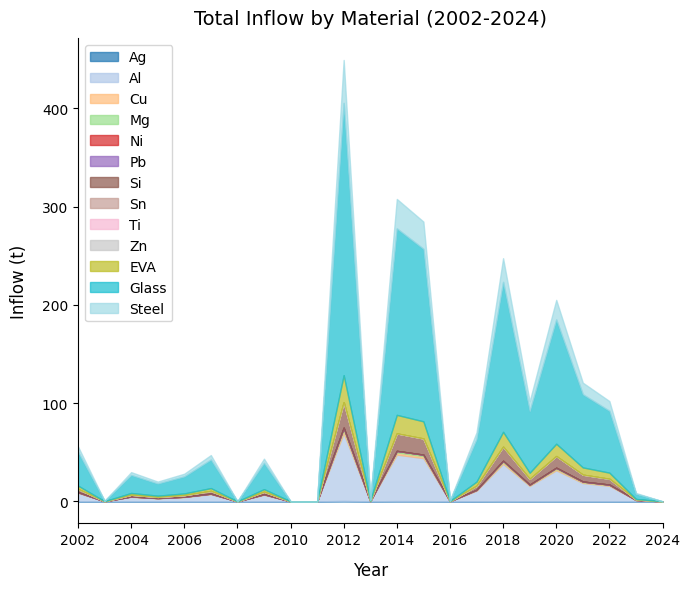

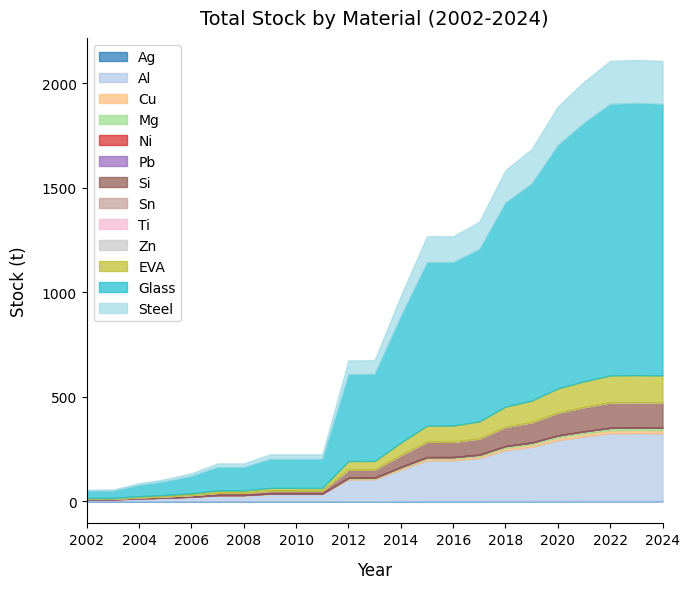

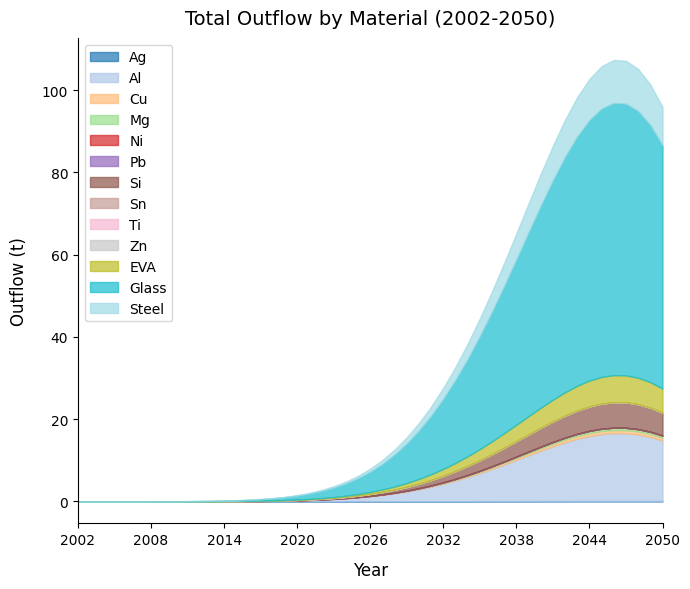

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Define ranges for inflow, stock, and outflow
inflow_years = list(range(2002, 2025))  # 2002–2024
stock_years = list(range(2002, 2025))  # 2002–2024
outflow_years = list(range(2002, 2051))  # 2002–2050

# Initialize dictionaries to hold aggregated data
inflow_aggregated = {material: [] for material in materials}
outflow_aggregated = {material: [] for material in materials}
stock_aggregated = {material: [] for material in materials}

total_inflow = {material: 0 for material in materials}
total_outflow = {material: 0 for material in materials}

# Populate data for inflow, stock, and outflow (convert kg to tons)
for year in inflow_years:
    for material in materials:
        inflow = total_inflow_by_year.get(year, {}).get(material, 0) / 1000  # Convert to tons
        inflow_aggregated[material].append(inflow)
        total_inflow[material] += inflow  # Aggregate total inflow

for year in stock_years:
    for material in materials:
        stock = stock_by_year.get(year, {}).get(material, 0) / 1000
        stock_aggregated[material].append(stock)

for year in outflow_years:
    for material in materials:
        outflow = outflow_by_year.get(year, {}).get(material, 0) / 1000
        outflow_aggregated[material].append(outflow)
        total_outflow[material] += outflow  # Aggregate total outflow


# Define color palette for materials
colors = plt.cm.get_cmap('tab20', len(materials))
figsize = (7, 6)  # Adjusted figure size

# --- Plot Inflow (Stacked) ---
plt.figure(figsize=figsize)
bottom = np.zeros(len(inflow_years))
for idx, material in enumerate(materials):
    plt.fill_between(
        inflow_years,
        bottom,
        bottom + inflow_aggregated[material],
        label=material,
        color=colors(idx),
        alpha=0.7
    )
    bottom += inflow_aggregated[material]
plt.title('Total Inflow by Material (2002-2024)', fontsize=14, pad=10)
plt.xlabel('Year', fontsize=12, labelpad=10)
plt.ylabel('Inflow (t)', fontsize=12, labelpad=10)
plt.xlim(2002, 2024)
plt.xticks(np.arange(2002, 2025, 2))

# Remove the right and top spines (borders)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Place the legend inside the plot (upper left)
plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

# --- Plot Stock (Stacked) ---
plt.figure(figsize=figsize)
bottom = np.zeros(len(stock_years))
for idx, material in enumerate(materials):
    plt.fill_between(
        stock_years,
        bottom,
        bottom + stock_aggregated[material],
        label=material,
        color=colors(idx),
        alpha=0.7
    )
    bottom += stock_aggregated[material]
plt.title('Total Stock by Material (2002-2024)', fontsize=14, pad=10)
plt.xlabel('Year', fontsize=12, labelpad=10)
plt.ylabel('Stock (t)', fontsize=12, labelpad=10)
plt.xlim(2002, 2024)
plt.xticks(np.arange(2002, 2025, 2))

# Remove the right and top spines (borders)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Place the legend inside the plot (upper left)
plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

# --- Plot Outflow (Stacked) ---
plt.figure(figsize=figsize)
bottom = np.zeros(len(outflow_years))
for idx, material in enumerate(materials):
    plt.fill_between(
        outflow_years,
        bottom,
        bottom + outflow_aggregated[material],
        label=material,
        color=colors(idx),
        alpha=0.7
    )
    bottom += outflow_aggregated[material]
plt.title('Total Outflow by Material (2002-2050)', fontsize=14, pad=10)
plt.xlabel('Year', fontsize=12, labelpad=10)
plt.ylabel('Outflow (t)', fontsize=12, labelpad=10)
plt.xlim(2002, 2050)
plt.xticks(np.arange(2002, 2051, 6))

# Remove the right and top spines (borders)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Place the legend inside the plot (upper left)
plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()


Recycling calculation and figure generation


Total Recycled Amount (tons) for Ideal scenario:
Ag: 1.05 t
Al: 241.06 t
Cu: 11.01 t
Mg: 3.08 t
Ni: 0.01 t
Pb: 0.07 t
Si: 89.46 t
Sn: 0.30 t
Ti: 0.00 t
Zn: 0.00 t
EVA: 0.00 t
Glass: 966.33 t
Steel: 145.11 t
All: 1457.49 t


C:\Users\79024\AppData\Local\Temp\ipykernel_64656\2484819972.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(materials))


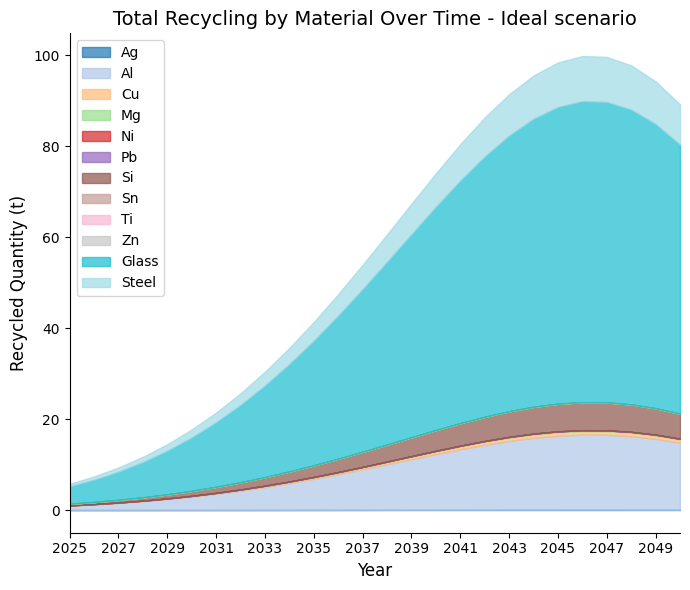


Total Recycled Amount (tons) for High scenario:
Ag: 0.97 t
Al: 223.35 t
Cu: 10.20 t
Mg: 2.86 t
Ni: 0.01 t
Pb: 0.07 t
Si: 82.89 t
Sn: 0.28 t
Ti: 0.00 t
Zn: 0.00 t
EVA: 0.00 t
Glass: 895.33 t
Steel: 134.44 t
All: 1350.40 t


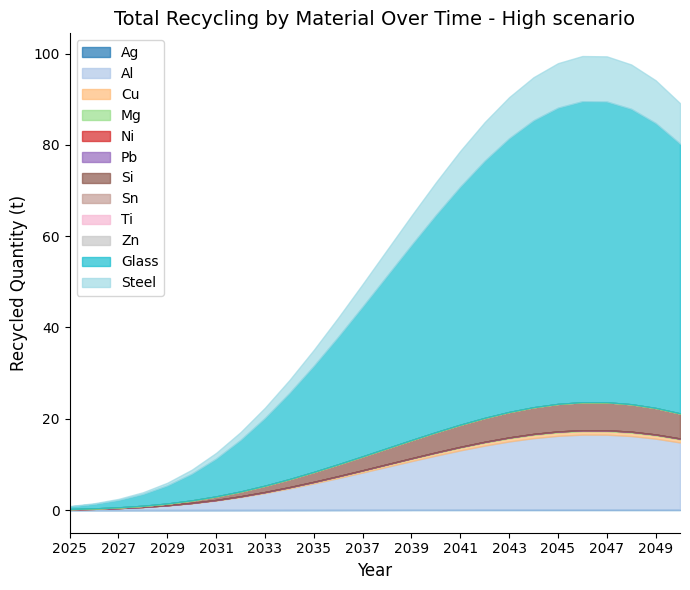


Total Recycled Amount (tons) for Low scenario:
Ag: 0.58 t
Al: 134.53 t
Cu: 6.15 t
Mg: 1.72 t
Ni: 0.00 t
Pb: 0.04 t
Si: 49.93 t
Sn: 0.17 t
Ti: 0.00 t
Zn: 0.00 t
EVA: 0.00 t
Glass: 539.27 t
Steel: 80.98 t
All: 813.37 t


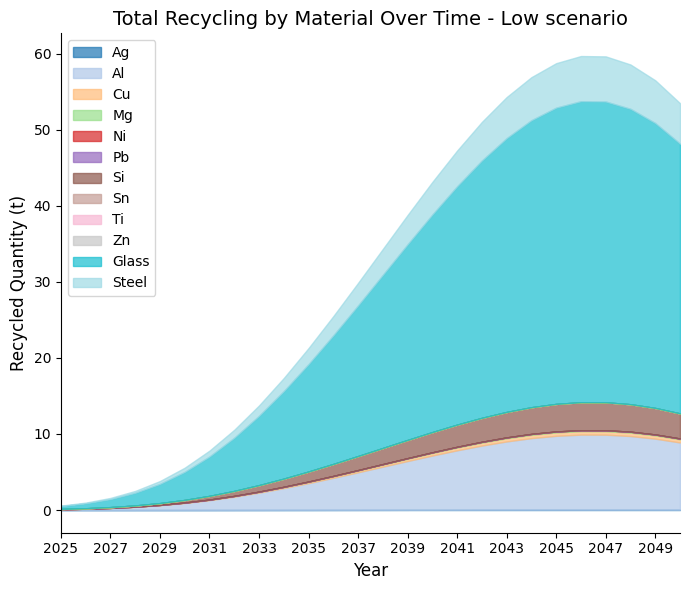

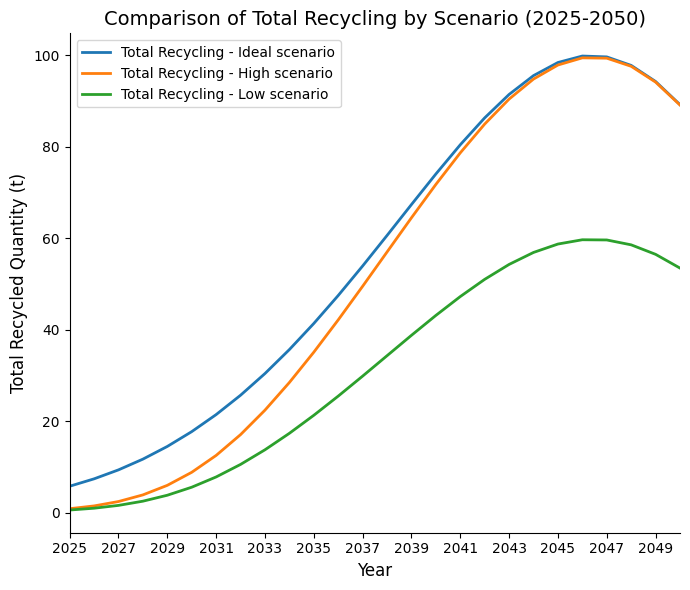

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load material flow data
df_CR = pd.read_excel(file_path_material_flow, sheet_name='CR')  # Collection Rate (CR) sheet
df_MMR = pd.read_excel(file_path_material_flow, sheet_name='MMR')  # Maximum Material Recovery Rate (MMR) sheet

# Ensure columns are clean
df_CR.columns = df_CR.columns.str.strip()
df_MMR.columns = df_MMR.columns.str.strip()

# Define the scenarios and extract materials from df_MMR columns
scenarios = ['Ideal scenario', 'High scenario', 'Low scenario']
materials = df_MMR.columns.tolist()  # Extract material names from MMR sheet

years = list(range(2025, 2051))  # Filter years from 2025 to 2050

# Initialize a dictionary to store aggregated recycling data for plotting
recycling_aggregated_by_scenario = {}
total_recycling_by_scenario = {scenario: np.zeros(len(years)) for scenario in scenarios}

for scenario in scenarios:
    recycling_aggregated = {material: [] for material in materials}
    total_recycling = {material: 0 for material in materials}
    total_recycling_all = 0  # Initialize total for all materials

    for year in years:
        if year in outflow_by_year:
            try:
                CR_value = df_CR.loc[df_CR['Year'] == year, scenario].values[0]
            except IndexError:
                print(f"CR value for Year {year} and Scenario {scenario} not found. Skipping year.")
                continue

            for material in materials:
                outflow = outflow_by_year[year].get(material, 0)
                adjusted_outflow = outflow * CR_value

                try:
                    MMR_value = df_MMR.loc[0, material]
                except KeyError:
                    print(f"MMR value for material {material} not found. Skipping material.")
                    continue

                recycling = adjusted_outflow * MMR_value
                recycling_aggregated[material].append(recycling / 1000)  # Convert to tons
                total_recycling[material] += recycling / 1000
                total_recycling_all += recycling / 1000  # Accumulate total for all materials
                
                total_recycling_by_scenario[scenario][years.index(year)] += recycling / 1000

    recycling_aggregated_by_scenario[scenario] = recycling_aggregated

    # Print total recycled amount for each material
    print(f"\nTotal Recycled Amount (tons) for {scenario}:")
    for material, total in total_recycling.items():
        print(f"{material}: {total:.2f} t")
    print(f"All: {total_recycling_all:.2f} t")  # Print total of all materials

    # Plotting individual scenario stacked area
    colors = plt.cm.get_cmap('tab20', len(materials))
    plt.figure(figsize=(7, 6))

    bottom = np.zeros(len(years))
    for idx, material in enumerate(materials):
        plt.fill_between(
            years,
            bottom,
            bottom + recycling_aggregated[material],
            label=material,
            color=colors(idx),
            alpha=0.7
        )
        bottom += recycling_aggregated[material]

    # Plot details
    plt.title(f'Total Recycling by Material Over Time - {scenario}', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Recycled Quantity (t)', fontsize=12)
    plt.xticks(np.arange(2025, 2050, 2), fontsize=10)
    plt.yticks(fontsize=10)

    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Filter legend to exclude EVA
    handles, labels = plt.gca().get_legend_handles_labels()
    filtered_handles_labels = [(h, l) for h, l in zip(handles, labels) if l != 'EVA']
    plt.legend(*zip(*filtered_handles_labels), loc='upper left', fontsize=10)

    plt.tight_layout()
    plt.xlim(2025, 2050)
    plt.grid(False)
    plt.show()

# --- Combine all scenarios into one plot (outline) ---
plt.figure(figsize=(7, 6))
for scenario in scenarios:
    plt.plot(
        years,
        total_recycling_by_scenario[scenario],
        label=f'Total Recycling - {scenario}',
        linewidth=2
    )

plt.title('Comparison of Total Recycling by Scenario (2025-2050)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Recycled Quantity (t)', fontsize=12)
plt.xticks(np.arange(2025, 2050, 2), fontsize=10)
plt.yticks(fontsize=10)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.xlim(2025, 2050)
plt.grid(False)
plt.show()

